In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)
model = model.to(device)
model.load_state_dict(torch.load("best_pneumonia_densenet121.pt", map_location=device))
model.eval()


C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_4564\4104618499.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_pneumonia_densenet1

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [4]:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229]) 
])

test_data = datasets.ImageFolder(
    r"D:\datasets\chest_xray\chest_xray\test",
    transform=val_test_transform
)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)


In [5]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam


In [6]:
target_layer = model.features.denseblock4
gradcam = GradCAM(model, target_layer)

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

In [7]:
input_tensor = images[0].unsqueeze(0)
true_label = labels[0].item()
cam = gradcam.generate(input_tensor)

c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [8]:
img = images[0].cpu().numpy().transpose(1, 2, 0)
img = (img * 0.229 + 0.485)  
img = np.clip(img, 0, 1)

In [9]:
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted((img * 255).astype(np.uint8), 0.5, heatmap, 0.5, 0)

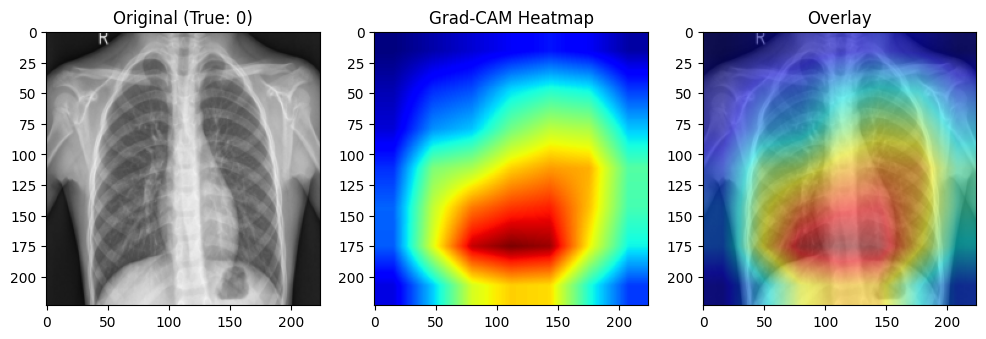

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Original (True: {true_label})")

plt.subplot(1,3,2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM Heatmap")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")

plt.show()

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [12]:
cam = GradCAM(model=model, target_layers=[target_layer])


In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [14]:
def run_gradcam_on_image(image_path, model, target_layer):
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    
    model.eval()
    output = model(input_tensor)
    pred = torch.argmax(output, 1).item()

    
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0, :]

    
    rgb_img = np.array(img.resize((224, 224))) / 255.0
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title(f"Original (Pred: {pred})")
    ax1.axis('off')

    ax2.imshow(grayscale_cam, cmap='jet')
    ax2.set_title("Grad-CAM Heatmap")
    ax2.axis('off')

    ax3.imshow(cam_image)
    ax3.set_title("Overlay")
    ax3.axis('off')

    plt.show()


In [15]:
def run_on_multiple_images(image_paths, model, target_layer):
    for img_path in image_paths:
        print(f"\nProcessing: {img_path}")
        run_gradcam_on_image(img_path, model, target_layer)


Processing: D:\datasets\chest_xray\val\PNEUMONIA\person1954_bacteria_4886.jpeg


c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


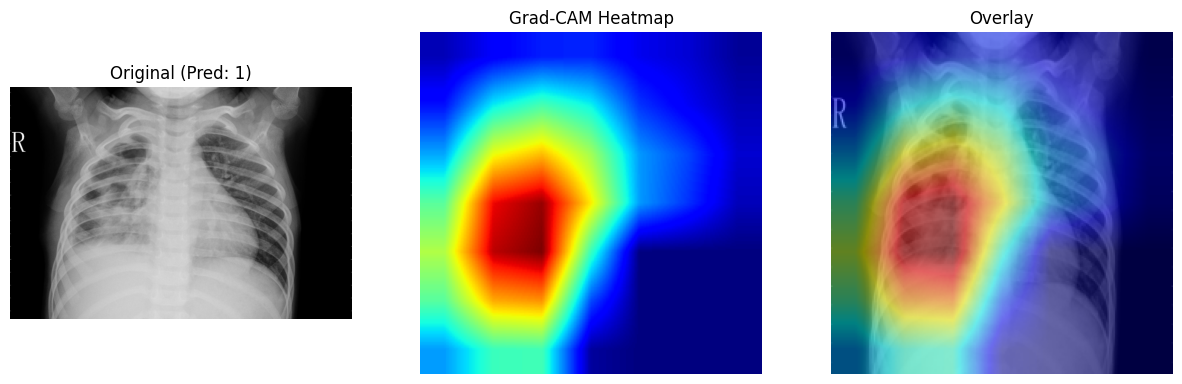


Processing: D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg


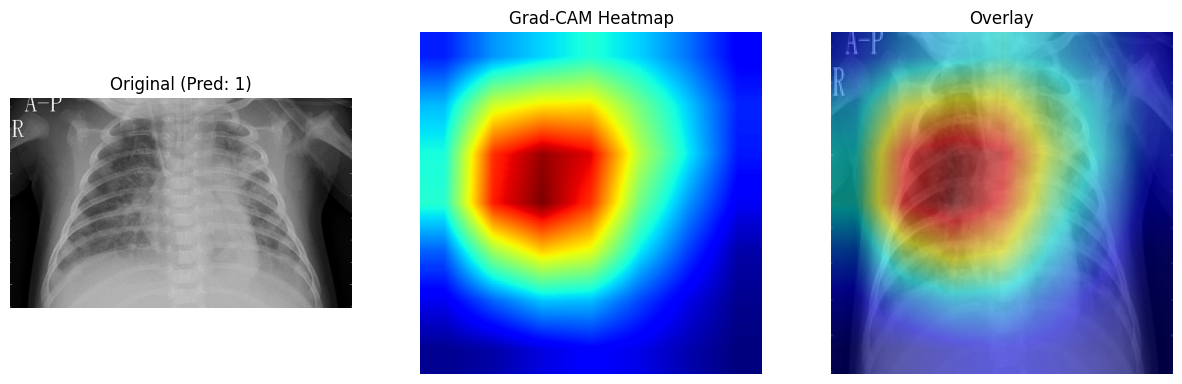


Processing: D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4875.jpeg


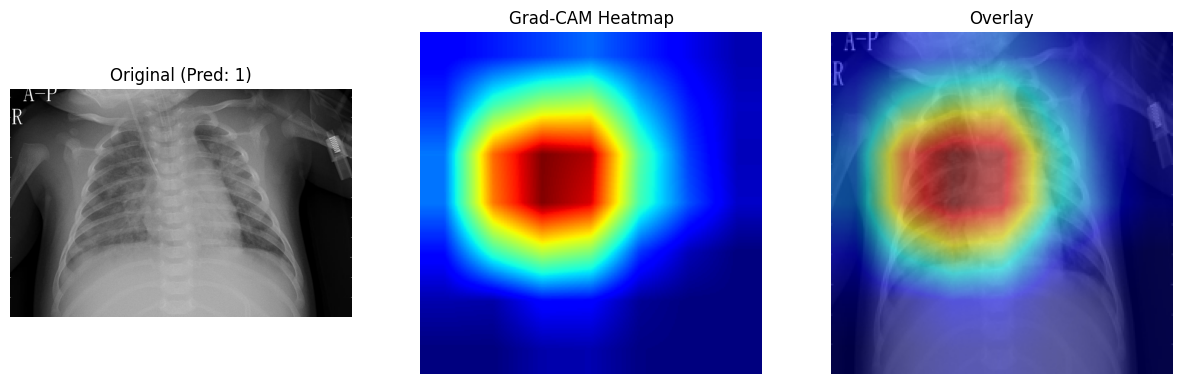


Processing: D:\datasets\chest_xray\val\PNEUMONIA\person1947_bacteria_4876.jpeg


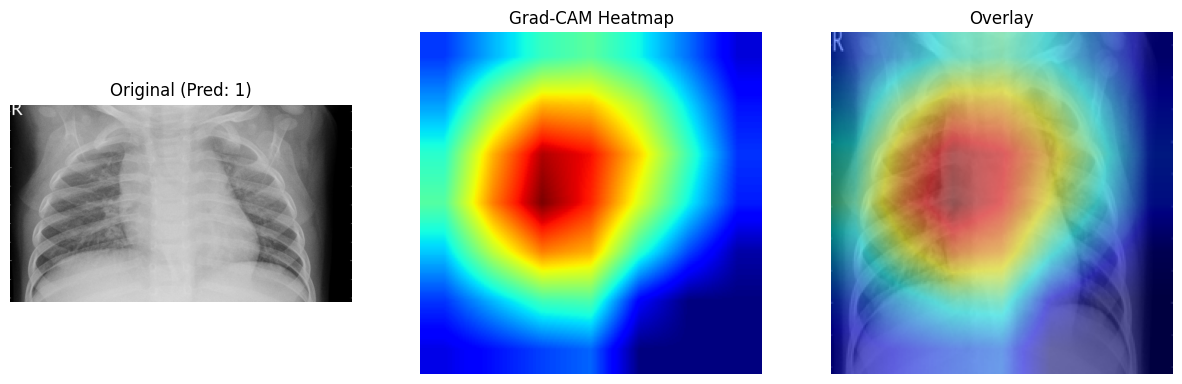


Processing: D:\datasets\chest_xray\val\PNEUMONIA\person1949_bacteria_4880.jpeg


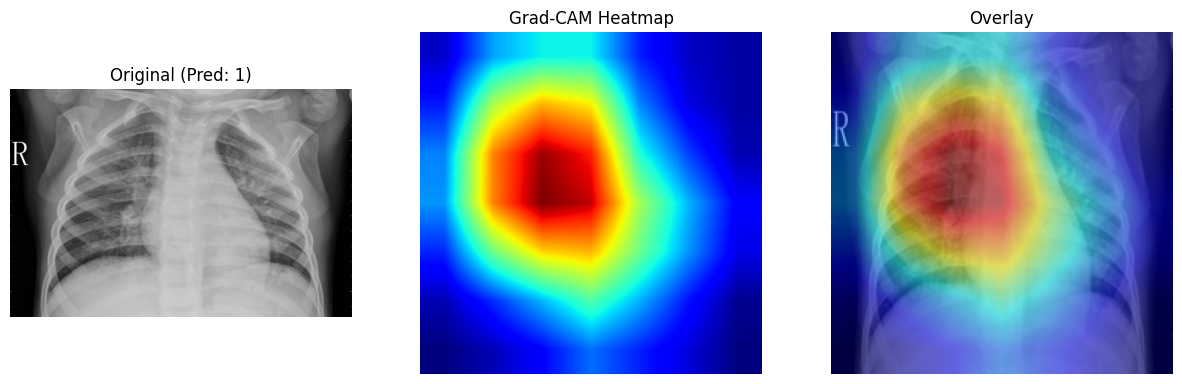


Processing: D:\datasets\chest_xray\val\PNEUMONIA\person1950_bacteria_4881.jpeg


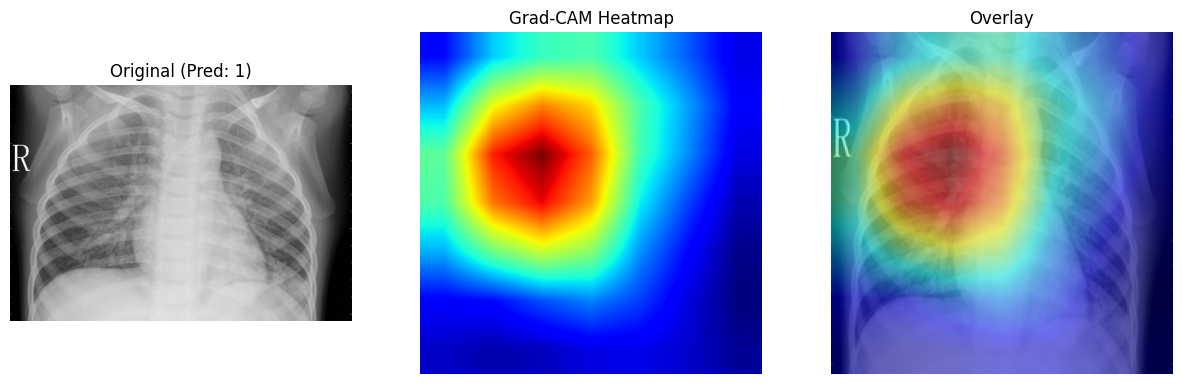


Processing: D:\datasets\chest_xray\val\PNEUMONIA\person1951_bacteria_4882.jpeg


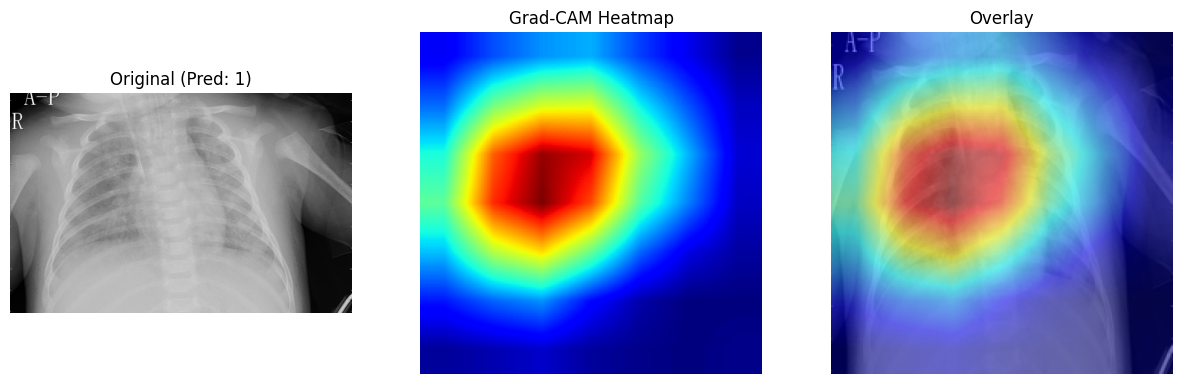


Processing: D:\datasets\chest_xray\val\PNEUMONIA\person1952_bacteria_4883.jpeg


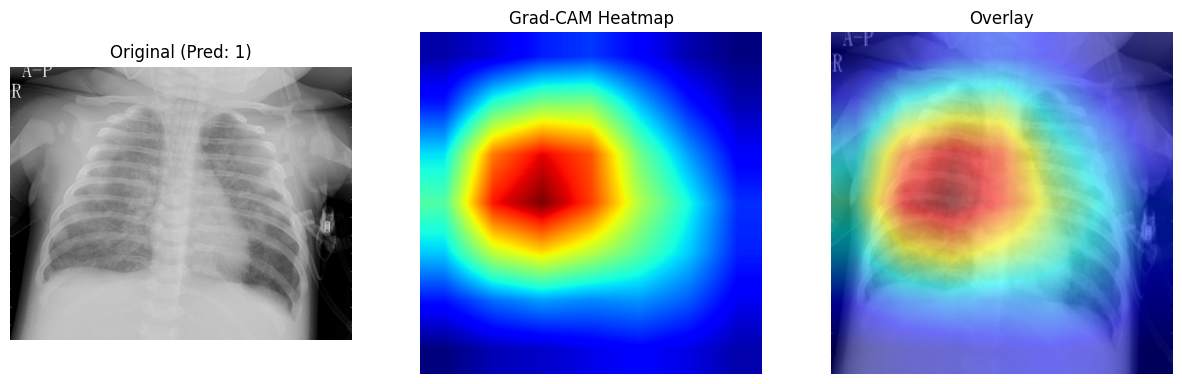

In [17]:
image_files = [
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1954_bacteria_4886.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4875.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1947_bacteria_4876.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1949_bacteria_4880.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1950_bacteria_4881.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1951_bacteria_4882.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1952_bacteria_4883.jpeg"
]

run_on_multiple_images(image_files, model, model.features[-1])